In [98]:
!git clone https://github.com/rajdeepmondal1/customer-segmentation

fatal: destination path 'customer-segmentation' already exists and is not an empty directory.


In [99]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [100]:
unzip_data('/content/customer-segmentation/data/ecommerce_data.zip')

In [173]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, warnings
import datetime as dt
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
%matplotlib inline

In [102]:
df = pd.read_csv('/content/data.csv', encoding= 'unicode_escape')

In [103]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


- What was the total revenue?
- Which months had the higher sales?
- What products are in the top 5 in sales and revenue?
- Which products were returned more frequently?
- What are the top 5 countries that purchased the most?
- How much is the share of the revenue for each cluster?

In [104]:
row, column = df.shape

In [105]:
print(f'Rows - {row}, Column - {column}')

Rows - 541909, Column - 8


In [106]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [107]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [108]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [109]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [110]:
df["CustomerID"].dtype

dtype('float64')

In [111]:
df=df.dropna()

In [112]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [113]:
df.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
countries = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count().reset_index(drop = False)['Country'].value_counts()

In [115]:
len(countries)

37

In [116]:
countries = pd.DataFrame(countries)
data = {
    'country': countries.index.tolist(),
    'no_of_order': countries.iloc[:, 0].tolist()
    }
orders_per_countries = pd.DataFrame(data)

In [117]:
orders_per_countries.head()

,country,no_of_order
0,United Kingdom,19857
1,Germany,603
2,France,458
3,EIRE,319
4,Belgium,119


In [118]:
orders_per_countries.to_csv('orders_per_country.csv')

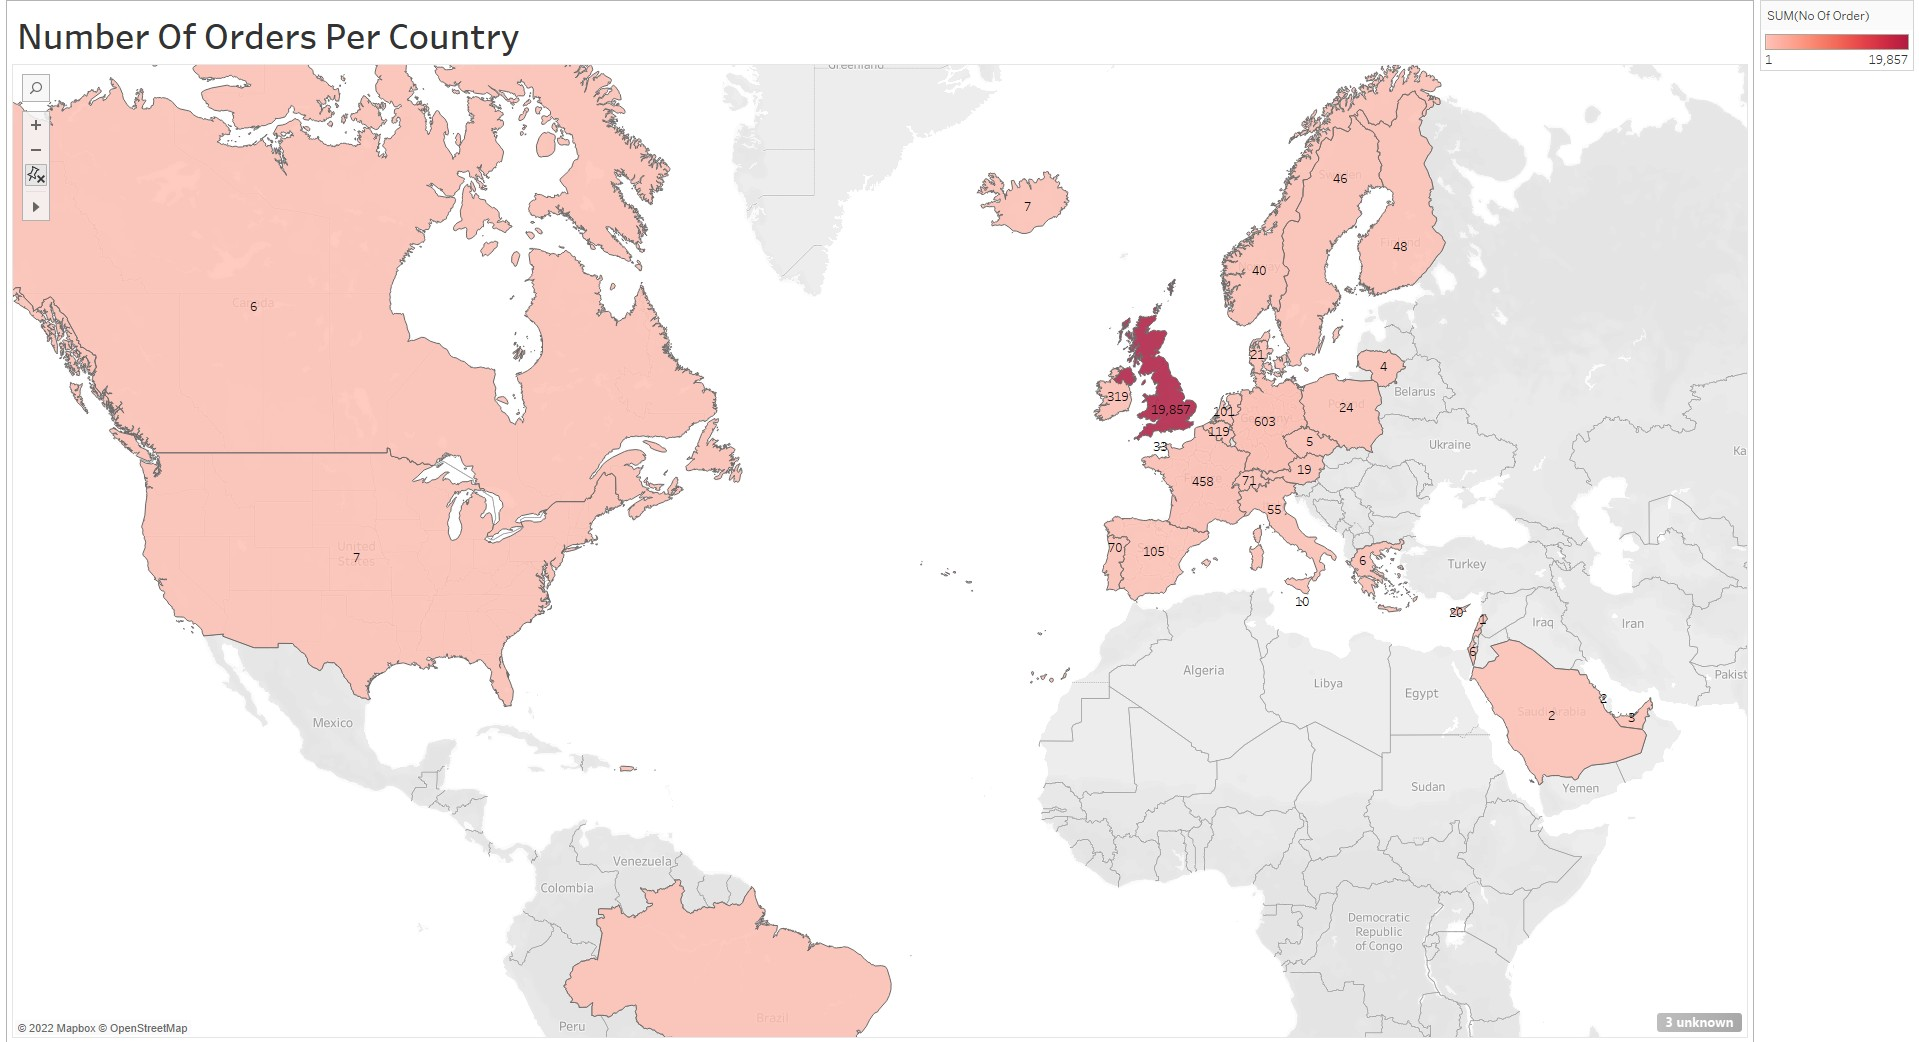

UK - highest sales

In [119]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


0 means not cancelled, vice versa

In [120]:
df.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [121]:
df["TotalRevenue"]=df["Quantity"]*df["UnitPrice"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue
463001,576052,22138,BAKING SET 9 PIECE RETROSPOT,2,2011-11-13 14:48:00,4.95,15787.0,United Kingdom,9.90
364507,568662,85032A,ROMANTIC IMAGES GIFT WRAP SET,1,2011-09-28 12:36:00,0.65,16764.0,United Kingdom,0.65
52582,540803,84929,ASSTD FRUIT+FLOWERS FRIDGE MAGNETS,24,2011-01-11 12:30:00,0.55,14669.0,United Kingdom,13.20
398098,571219,22630,DOLLY GIRL LUNCH BOX,12,2011-10-14 13:35:00,1.95,15601.0,United Kingdom,23.40
309837,564141,20754,RETROSPOT RED WASHING UP GLOVES,2,2011-08-23 11:47:00,2.10,17841.0,United Kingdom,4.20


In [123]:
round(df["TotalRevenue"].sum(),2)

8278519.42

total revenue

In [124]:
df['OrderStatus'] = [1 if 'C' in str(i) else 0 for i in df['InvoiceNo']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [125]:
df['OrderStatus'].value_counts()

0    392732
1      8872
Name: OrderStatus, dtype: int64

In [126]:
df[df["Quantity"]<=0]['OrderStatus'].value_counts()

1    8872
Name: OrderStatus, dtype: int64

In [127]:
df_orders = df[df["OrderStatus"]==0]

In [128]:
df_orders['Quantity'].min()

1

In [129]:
df_orders['Quantity'].min()
df_orders["TotalRevenue"] = df_orders["Quantity"] * df_orders["UnitPrice"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [130]:
round(df_orders["TotalRevenue"].sum(),2)

8887208.89

In [131]:
df_cancelled = df[df["OrderStatus"]==1]

In [132]:
df_cancelled

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,OrderStatus
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,1
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13,1
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69,1
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75,1
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25,1


In [136]:
total_orders = df_cancelled['InvoiceNo'].nunique() + df_orders['InvoiceNo'].nunique()
total_orders

22190

In [137]:
cancelled_orders = df_cancelled['InvoiceNo'].nunique()
cancelled_orders

3654

In [145]:
real_orders=df_orders["InvoiceNo"].nunique()
real_orders

18536

In [158]:
percentage_of_cancelled_orders = round((cancelled_orders * 100 / total_orders), 2)

In [146]:
percentage_of_real_orders = round((real_orders * 100 / total_orders), 2)

In [143]:
print(f'Percentage of cancelled orders - {percentage_of_cancelled_orders}%')

Percentage of cancelled orders - 16.47%


In [147]:
print(f'Percentage of real orders - {percentage_of_real_orders}%')

Percentage of real orders - 83.53%


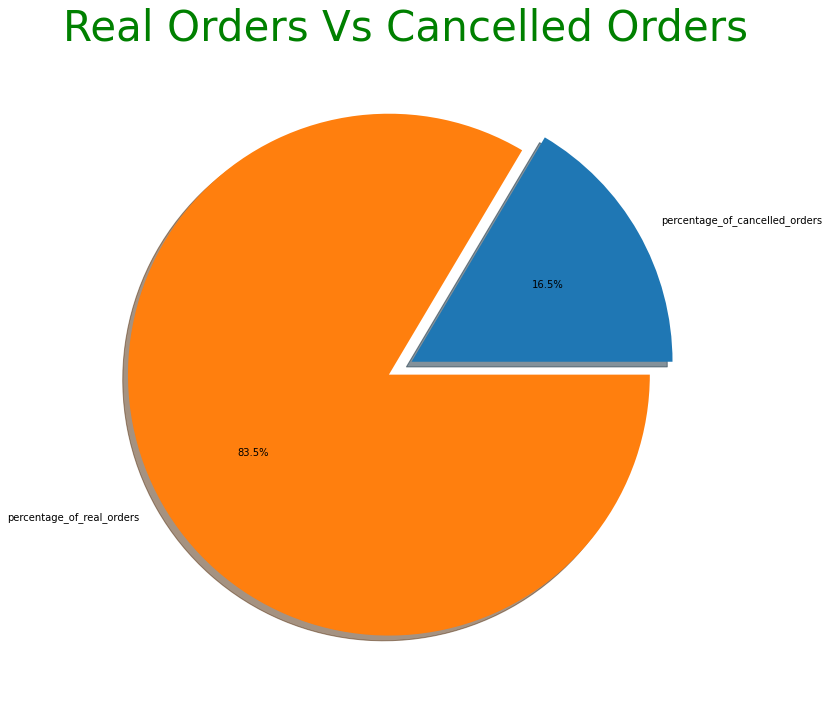

In [171]:
fig = plt.figure(figsize =(18, 12))
plt.pie([percentage_of_cancelled_orders, percentage_of_real_orders], 
        labels = ["percentage_of_cancelled_orders", "percentage_of_real_orders"],
        autopct="%1.1f%%",
        shadow=True,
        explode=(0.1,0))
plt.title('Real Orders Vs Cancelled Orders', 
          loc='left',
          fontsize=42,
          color="green")
plt.show()

In [172]:
df_orders


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,OrderStatus
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0


In [175]:
#In which months the sales were higher?
df_orders["InvoiceDate"] = pd.to_datetime(df_orders["InvoiceDate"])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [176]:
df_orders["InvoiceDate"]

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 392732, dtype: datetime64[ns]

In [177]:
df_orders["Month"]=df_orders["InvoiceDate"].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [183]:
df_orders["Month"].value_counts()

11    63182
10    48796
12    42699
9     39671
5     28075
6     26926
3     26872
8     26796
7     26582
4     22435
1     20991
2     19707
Name: Month, dtype: int64

In [179]:
df_orders["Year"] = df_orders["InvoiceDate"].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [180]:
df_orders["Year"].value_counts()

2011    367059
2010     25673
Name: Year, dtype: int64

In [181]:
total_revenue_per_month = df_orders.groupby(['Year', 'Month'])['TotalRevenue'].sum()

In [184]:
total_revenue_per_month

Year  Month
2010  12        570422.730
2011  1         568101.310
      2         446084.920
      3         594081.760
      4         468374.331
      5         677355.150
      6         660046.050
      7         598962.901
      8         644051.040
      9         950690.202
      10       1035642.450
      11       1156205.610
      12        517190.440
Name: TotalRevenue, dtype: float64

In [187]:
total_revenue_per_month.to_csv('total_revenue_per_month.csv')

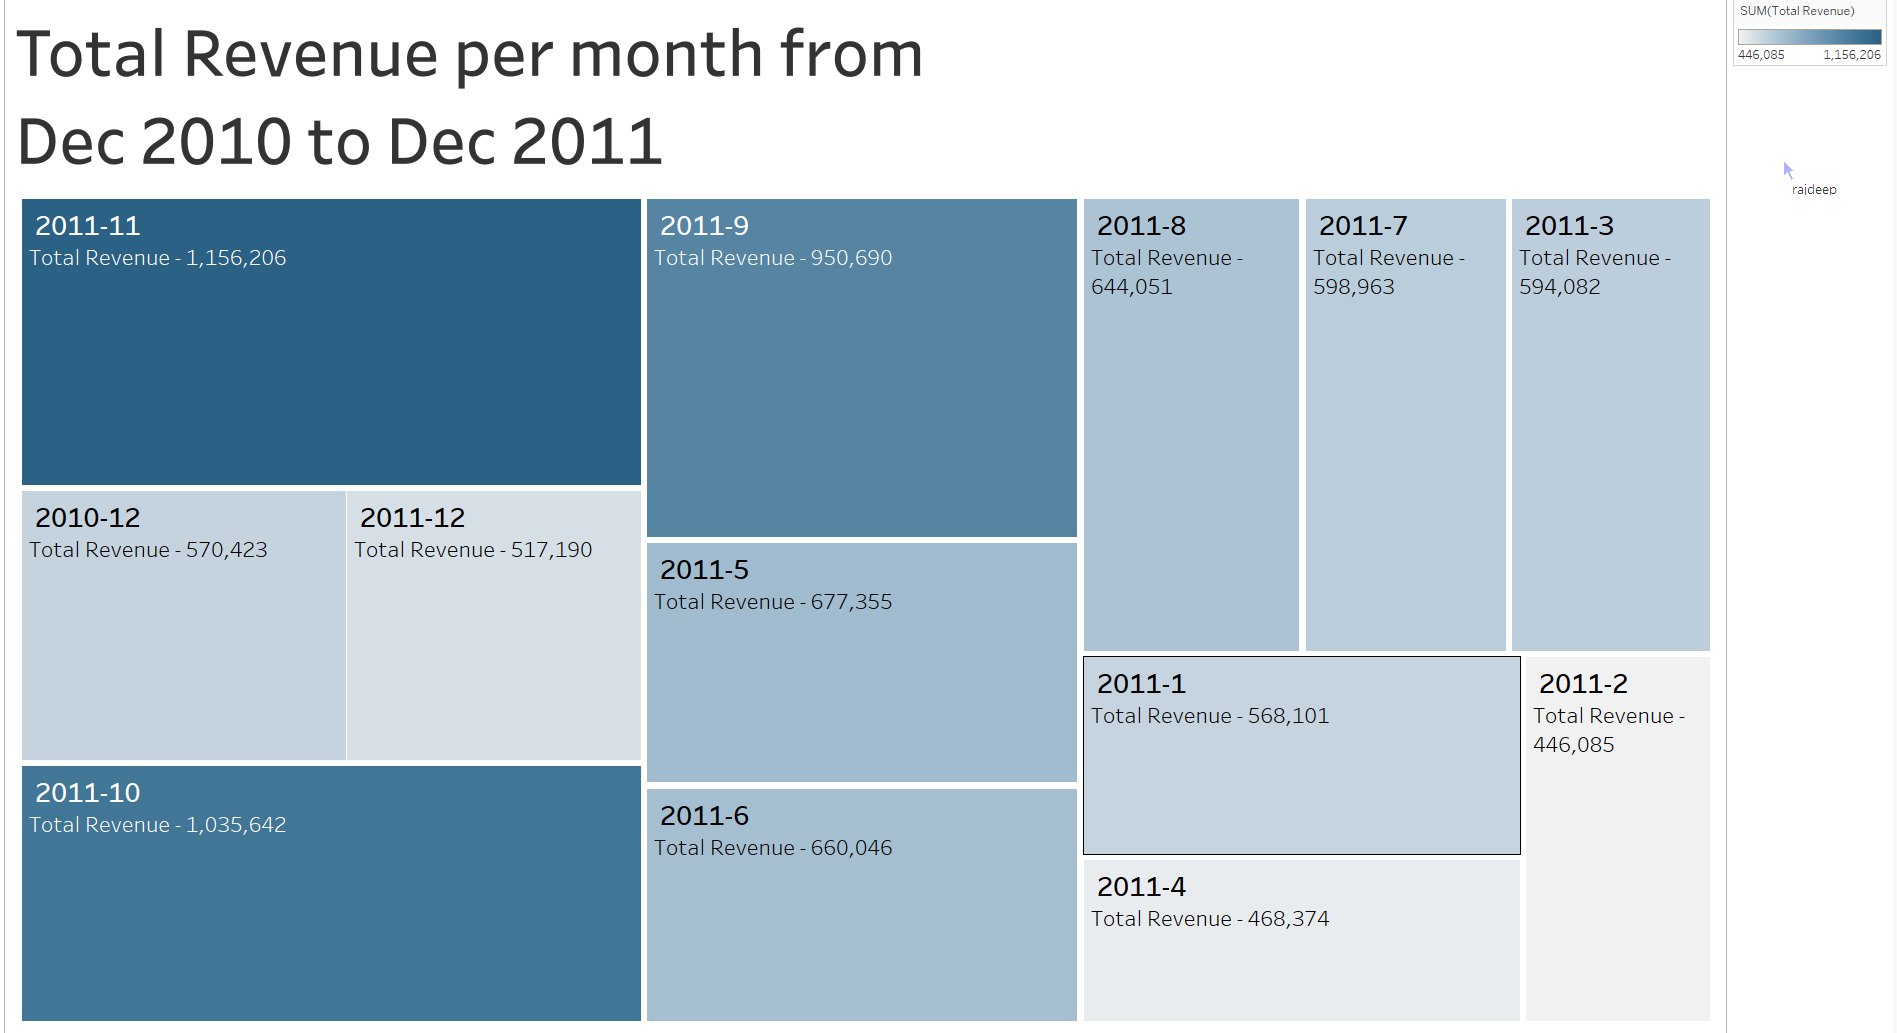